In [512]:
import numpy as np
from scipy.signal import convolve2d
from scipy import stats
from PIL import Image
%matplotlib inline
import time


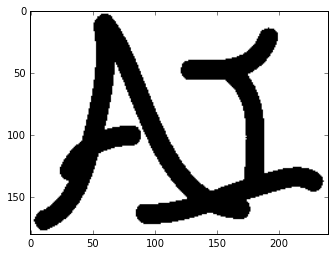

In [513]:
img = Image.open('in.png')
plt.imshow(img,cmap=cm.gray)
plt.show()


In [575]:
def E_generator(beta, eta, h):
    """Generate energy function E and localized version of E.

    Usage: E, localized_E = E_generator(beta, eta, h)
    Formula:
        E = h * \sum{x_i} - beta * \sum{x_i x_j} - eta * \sum{x_i y_i}
    """
    def E(x, y):
        """Calculate energy for matrices x, y.

        Note: the computation is not localized, so this is quite expensive.
        """
        # sum of products of neighboring paris {xi, yi}
        xxm = np.zeros_like(x)
        xxm[:-1, :] = x[1:, :]  # down
        xxm[1:, :] += x[:-1, :]  # up
        xxm[:, :-1] += x[:, 1:]  # right
        xxm[:, 1:] += x[:, :-1]  # left
        xx = np.sum(xxm * x)
        xy = np.sum(x * y)
        xsum = np.sum(x)
        return h * xsum - beta * xx - eta * xy

    def is_valid(i, j, shape):
        """Check if coordinate i, j is valid in shape."""
        return i >= 0 and j >= 0 and i < shape[0] and j < shape[1]

    def localized_E(E1, i, j, x, y):
        """Localized version of Energy function E.

        Usage: old_x_ij, new_x_ij, E1, E2 = localized_E(Ecur, i, j, x, y)
        """
        oldval = x[i, j]
        newval = oldval * -1  # flip
        # local computations
        E2 = E1 - (h * oldval) + (h * newval)
        E2 = E2 + (eta * y[i, j] * oldval) - (eta * y[i, j] * newval)
        adjacent = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        neighbors = [x[i + di, j + dj] for di, dj in adjacent
                     if is_valid(i + di, j + dj, x.shape)]
        E2 = E2 + beta * sum(a * oldval for a in neighbors)
        E2 = E2 - beta * sum(a * newval for a in neighbors)
        return oldval, newval, E1, E2

    return E, localized_E

In [576]:
def ICM(y, E, localized_E):
    """Greedy version of simulated_annealing()."""
    x = np.array(y)
    Ebest = Ecur = E(x, y)  # initial energy
    initial_time = time.time()
    energy_record = [[0.0, ], [Ebest, ]]
    accept,reject=0,0
    for idx in np.ndindex(y.shape):  # for each pixel in the matrix
        old, new, E1, E2 = localized_E(Ecur, idx[0], idx[1], x, y)
        if (E2 < Ebest):
            Ecur, x[idx] = E2, new
            Ebest = E2  # update Ebest
        else:
            Ecur, x[idx] = E1, old

    end_time = time.time()
    energy_record[0].append(end_time-initial_time)
    energy_record[1].append(Ebest)

    return x, energy_record

In [577]:
def sign(data, translate):
    """Map a dictionary for the element of data.

    Example:
        To convert every element in data with value 0 to -1, 255 to 1,
        use `signed = sign(data, {0: -1, 255: 1})`
    """
    temp = np.array(data)
    return np.vectorize(lambda x: translate[x])(temp)


In [578]:
def flip(data, density):
    """Flip the data (between 1 and -1) with given density.

    Returns
    ---------
    temp: flipped data
    """
    data_len, temp = len(data), np.array(data)
    for i in xrange(data_len):
        p = np.random.rand()
        if p < density:
            temp[i] *= -1
    return temp

In [589]:
im= Image.open ( 'in.png' )
data = sign(im.getdata(), {0: -1, 255: 1})  # convert to {-1, 1}
data=flip(data,0.1)
E, localized_E = E_generator(1e-3, 2.1e-3, 0)
y = data.reshape(im.size[::-1])  # convert 1-d array to matrix

In [590]:
result, energy_record = ICM(y, E, localized_E)

In [591]:
result = sign(result, {-1: 0, 1: 255})
output_image = Image.fromarray(result).convert('1', dither=Image.NONE)

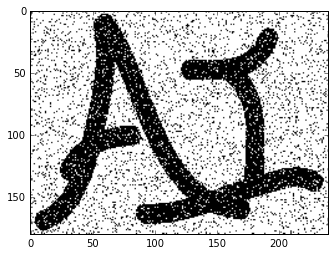

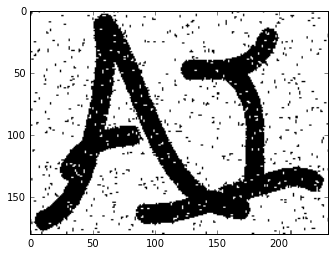

In [592]:
data=data.reshape(im.size [ :: - 1])
plt.imshow(data,cmap=plt.cm.gray)
plt.show()         
plt.imshow(output_image)
plt.show()

In [608]:
def temperature(k, kmax):
    """Schedule the temperature for simulated annealing."""
    return 1.0 / 500 * (1.0 / k - 1.0 / kmax)


def prob(E1, E2, t):
    """Probability transition function for simulated annealing."""
    return 1 if E1 > E2 else np.exp((E1 - E2) / t)


def simulated_annealing(y, kmax, E, localized_E):
    """Simulated annealing process for image denoising.

    Parameters
    ----------
    y: array_like
        The noisy binary image matrix ranging in {-1, 1}.
    kmax: int
        The maximun number of iterations.
    E: function
        Energy function.
    localized_E: function
        Localized version of E.
    temp_dir: path
        Directory to save temporary results.

    Returns
    ----------
    x: array_like
        The denoised binary image matrix ranging in {-1, 1}.
    energy_record:
        [time, Ebest] records for plotting.
    """
    x = np.array(y)
    Ebest = Ecur = E(x, y)  # initial energy
    initial_time = time.time()
    energy_record = [[0.0, ], [Ebest, ]]

    for k in range(1, kmax + 1):  # iterate kmax times
        start_time = time.time()
        t = temperature(k, kmax + 1)
        print "k = %d, Temperature = %.4e" % (k, t)
        accept, reject = 0, 0
        for idx in np.ndindex(y.shape):  # for each pixel in the matrix
            old, new, E1, E2 = localized_E(Ecur, idx[0], idx[1], x, y)
            p, q = prob(E1, E2, t), np.random.rand()
            if p > q:
                accept += 1
                Ecur, x[idx] = E2, new
                if (E2 < Ebest):
                    Ebest = E2  # update Ebest
            else:
                reject += 1
                Ecur, x[idx] = E1, old

        # record time and Ebest of this iteration
        end_time = time.time()
        energy_record[0].append(end_time - initial_time)
        energy_record[1].append(Ebest)

        print "--- k = %d, accept = %d, reject = %d ---" % (k, accept, reject)
        print "--- k = %d, %.1f seconds ---" % (k, end_time - start_time)

    return x, energy_record

In [613]:
im= Image.open ( 'in.png' )
data = sign(im.getdata(), {0: -1, 255: 1})  # convert to {-1, 1}
data=flip(data,0.1)
E, localized_E = E_generator(1e-3, 2.1e-3, 0)
y = data.reshape(im.size[::-1])  # convert 1-d array to matrix
result, energy_record = simulated_annealing(y, 10, E, localized_E)

k = 1, Temperature = 1.8182e-03
--- k = 1, accept = 4252, reject = 38948 ---
--- k = 1, 0.5 seconds ---
k = 2, Temperature = 8.1818e-04
--- k = 2, accept = 795, reject = 42405 ---
--- k = 2, 0.6 seconds ---
k = 3, Temperature = 4.8485e-04
--- k = 3, accept = 325, reject = 42875 ---
--- k = 3, 0.6 seconds ---
k = 4, Temperature = 3.1818e-04
--- k = 4, accept = 193, reject = 43007 ---
--- k = 4, 0.6 seconds ---
k = 5, Temperature = 2.1818e-04
--- k = 5, accept = 149, reject = 43051 ---
--- k = 5, 0.6 seconds ---
k = 6, Temperature = 1.5152e-04
--- k = 6, accept = 111, reject = 43089 ---
--- k = 6, 0.6 seconds ---
k = 7, Temperature = 1.0390e-04
--- k = 7, accept = 64, reject = 43136 ---
--- k = 7, 0.6 seconds ---
k = 8, Temperature = 6.8182e-05
--- k = 8, accept = 39, reject = 43161 ---
--- k = 8, 0.6 seconds ---
k = 9, Temperature = 4.0404e-05
--- k = 9, accept = 13, reject = 43187 ---
--- k = 9, 0.6 seconds ---
k = 10, Temperature = 1.8182e-05
--- k = 10, accept = 0, reject = 43200 ---

In [614]:
result = sign(result, {-1: 0, 1: 255})
output_image = Image.fromarray(result).convert('1', dither=Image.NONE)

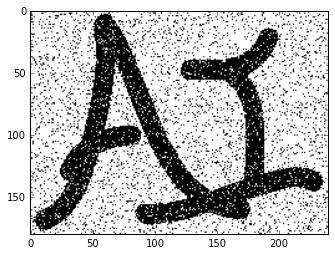

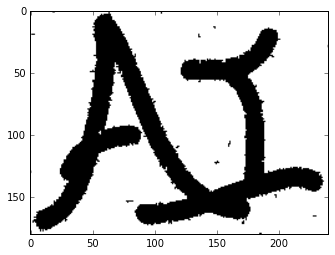

In [615]:
data=data.reshape(im.size [ :: - 1])
plt.imshow(data,cmap=plt.cm.gray)
plt.show()         
plt.imshow(output_image)
plt.show()